In [1]:
from utilities.VGChartz import get_games_data
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from rich import print
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression,LassoCV,RidgeCV

from sklearn.model_selection import cross_val_score, train_test_split,KFold, GridSearchCV


In [2]:
df = get_games_data()

In [3]:
# df = pd.get_dummies(df, columns=['Genre', 'Console'])

In [4]:
# x.T.fillna(x.T.mean()).T
temp = df[['VGChartz Score', 'Critic Score', 'User Score']]
temp=temp.T.fillna(temp.T.mean()).T
df[['VGChartz Score', 'Critic Score', 'User Score']] = temp
df['Score'] = (df['VGChartz Score'] +df['Critic Score'] + df['User Score'])/3

In [5]:
df =df.dropna(subset=['Score'])

In [6]:
df1 = df.copy(deep=True)
df2 = df.copy(deep=True)
df3 = df.copy(deep=True)
df4 = df.copy(deep=True)

In [7]:
df1 = df1[['Score', 'VGChartz Score', 'Critic Score', 'User Score']]
df2 = pd.get_dummies(df2[['Score','VGChartz Score', 'Genre']], columns=['Genre'])
df3 = pd.get_dummies(df3[['Score', 'VGChartz Score','Console']], columns=['Console'])
df4 = pd.get_dummies(df[['Score','VGChartz Score','Genre', 'Console']], columns=['Console', 'Genre'])

In [8]:
def linear_regression_score(X, y, kfold:int=5, scoring_type:str='r2'):
    lm = LinearRegression()
    result = cross_val_score(lm, X, y, cv=kfold, scoring=scoring_type)
    return np.mean(result)

def lasso_score(X, y, X_val,y_val ,kfold:int=5, scoring_type:str='r2'):
    alphas = 10**np.linspace(6,-2,50)*0.5
    lasso = Lasso(max_iter=10000, normalize=True)
    
    lassocv = LassoCV(alphas=None, cv=kfold, max_iter=100000, normalize=True)
    lassocv.fit(X_val, y_val)
    lasso.set_params(alpha=lassocv.alpha_)
    clf = Lasso(alpha=lassocv.alpha_)
    scores = cross_val_score(clf, X, y, cv=kfold)
    return scores.mean()
    
def riggid_score(X,y,X_val,y_val,kfold:int=5):
    alphas = 10**np.linspace(6,-2,50)*0.5
    ridgecv = RidgeCV(alphas=alphas, normalize=True)
    ridgecv.fit(X_val, y_val)
    ridge6 = Ridge(alpha=ridgecv.alpha_, normalize=True)
    ridge6.fit(X, y)
    score = cross_val_score(ridge6, X, y, cv=kfold)
    return score.mean()
    
def poly_score(X,y,X_val,y_val,degree:int=2,kfold:int=5):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_val)
    poly = LinearRegression()
    return np.mean(cross_val_score(poly, X_poly, y_val, cv=kfold))

In [9]:
def find_scores(df):
    kfold = KFold(n_splits=20, shuffle=True, random_state=0)
    X, X_test, y, y_test = train_test_split(df.loc[:, df.columns != 'Score'], df['Score'], test_size=0.2, random_state=64)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=64)
    linear_score = linear_regression_score(X_train, y_train)
    lassov_score = lasso_score(X_train, y_train,X_val,y_val,kfold=10)
    riggidv_score = riggid_score(X_train, y_train,X_val,y_val,kfold=10)
    polyv_score = poly_score(X_train, y_train,X_val,y_val,degree=3,kfold=10)
    return {'Linear Score':linear_score,'Lasso Score':lassov_score,'Riggid Score':riggidv_score,'Polynomial Score':polyv_score}



In [10]:
dfScores=pd.DataFrame([find_scores(df1),find_scores(df2),find_scores(df3),find_scores(df4),])
dfScores

,Linear Score,Lasso Score,Riggid Score,Polynomial Score
0,1.000000e+00,1.000000,0.999997,1.000000e+00
1,9.434099e-01,0.943194,0.942808,-6.552325e+17
2,9.431972e-01,0.943298,0.942905,-3.571255e+18
3,-1.202362e+22,0.943063,0.942132,-1.351399e+20


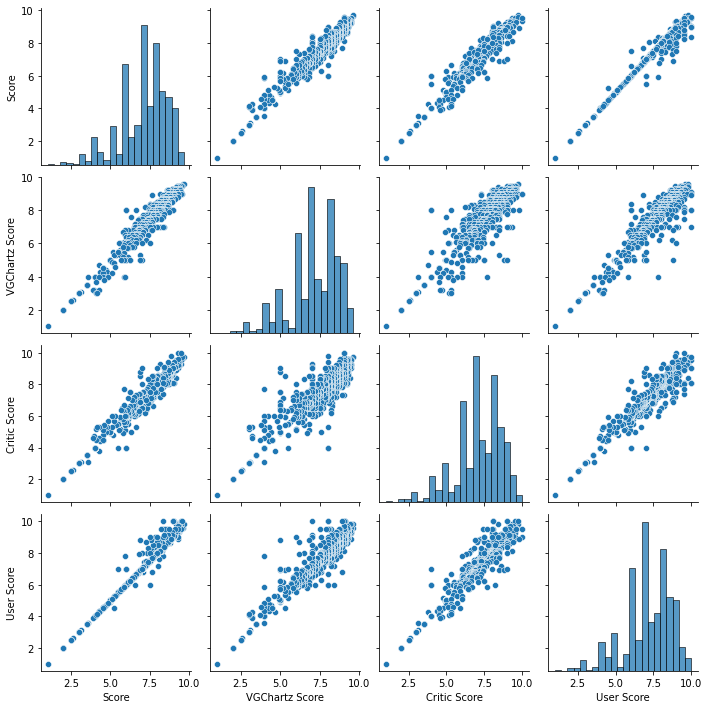

In [11]:
sns.pairplot(df[['Score', 'VGChartz Score', 'Critic Score', 'User Score']])

In [12]:
df4.corr()

,Score,VGChartz Score,Console_3DS,Console_DS,Console_DSiW,Console_GC,Console_NS,Console_PC,Console_PS2,Console_PS3,...,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel
Score,1.000000,0.978594,0.010680,0.073198,-0.006690,0.059963,-0.164689,-0.043053,0.040949,0.190729,...,0.068952,-0.000070,0.066767,0.090732,-0.001899,0.029395,-0.007265,0.002703,0.030535,-0.092902
VGChartz Score,0.978594,1.000000,0.014400,0.083406,-0.023186,0.055192,-0.185545,-0.035257,0.049480,0.190349,...,0.061596,0.001863,0.066726,0.090297,-0.001237,0.034198,-0.010426,0.003111,0.033015,-0.089285
Console_3DS,0.010680,0.014400,1.000000,-0.015676,-0.003305,-0.002697,-0.032568,-0.023036,-0.006909,-0.020673,...,-0.019702,-0.013770,-0.014196,0.048297,-0.001906,-0.023433,-0.009229,-0.013479,-0.014611,-0.004679
Console_DS,0.073198,0.083406,-0.015676,1.000000,-0.012132,-0.009902,-0.119569,-0.084575,-0.025364,-0.075900,...,-0.031646,0.042339,-0.034049,0.127917,-0.006999,-0.062437,-0.006814,-0.030544,0.051968,-0.017180
Console_DSiW,-0.006690,-0.023186,-0.003305,-0.012132,1.000000,-0.002087,-0.025205,-0.017829,-0.005347,-0.016000,...,0.045744,-0.010657,-0.010987,-0.020574,-0.001475,-0.018136,-0.007143,-0.010432,-0.011308,-0.003622
Console_GC,0.059963,0.055192,-0.002697,-0.009902,-0.002087,1.000000,-0.020571,-0.014551,-0.004364,-0.013058,...,0.062224,-0.008698,-0.008967,-0.016792,-0.001204,0.050148,-0.005829,-0.008514,-0.009229,-0.002956
Console_NS,-0.164689,-0.185545,-0.032568,-0.119569,-0.025205,-0.020571,1.000000,-0.175707,-0.052694,-0.157683,...,0.088624,-0.062800,-0.087741,-0.062421,-0.014540,-0.044666,0.037276,0.015598,-0.031434,-0.005796
Console_PC,-0.043053,-0.035257,-0.023036,-0.084575,-0.017829,-0.014551,-0.175707,1.000000,-0.037272,-0.111534,...,-0.027800,0.019795,-0.050443,-0.019119,-0.010285,0.044270,0.067710,-0.045312,0.086713,0.012817
Console_PS2,0.040949,0.049480,-0.006909,-0.025364,-0.005347,-0.004364,-0.052694,-0.037272,1.000000,-0.033449,...,-0.002452,-0.022279,-0.022968,0.073484,-0.003084,-0.037914,-0.014932,-0.021810,-0.023641,-0.007571
Console_PS3,0.190729,0.190349,-0.020673,-0.075900,-0.016000,-0.013058,-0.157683,-0.111534,-0.033449,1.000000,...,-0.041901,-0.066668,0.102302,-0.001649,-0.009230,0.044739,-0.023332,0.069228,-0.042975,-0.022656


In [13]:
sns.heatmap(df[['VGChartz Score', 'Critic Score', 'User Score', 'Total Shipped', 'Total Sales']])

ValueError: could not convert string to float: '12.80m'